In [1]:
from HARK.frame import (
    BackwardFrameReference,
    ForwardFrameReference,
    Frame,
    FrameAgentType,
    FrameModel,
    draw_frame_model
)

from HARK.distribution import combine_indep_dstns, add_discrete_outcome_constant_mean
from HARK.distribution import (
    IndexDistribution,
    Lognormal,
    MeanOneLogNormal,
    Bernoulli  # Random draws for simulating agents
)

from HARK.utilities import (
    CRRAutility,
)

TO DO:

Refactor to separate model from simulator (AgentType)

- [x] Separate FrameModel from FrameAgentType - AgentType has cycles parameter. FrameModel need not have it.
- [x] Define Repeater transformation -- transforms FrameModel to be either explicitly infinite or to become finite cycled. Can take age-varying parameters here (and only here).
- [x] FrameAgentType consumes a FrameModel, and runs simulations in HARK way
- [ ] Further decouple FrameModel from FrameAgentType.
  - [x] FrameModel should take parameters dictionary
  - [x] Generalize simulation to access appropriate solution (transition_cNrm) 
  - [ ] FrameModel transition equations should not reference 'self' whiteboard
  - [ ] FrameAgentType with an arbitrary well-formed FrameModel and solution should be able to forward-simulate
  - [ ] Replicate the ConsPortfolioFrameModel with new architecture.
- [ ] Automated tests

Solver as something that consumes and works with a FrameModel

- [ ] Data structure for the solution of a model? -- A policy. (Look at Bellman library?)
- [ ] Extract the key sequence of variables along which to pass value
- [ ] Value-passing -- inverse function 
- [ ] Value-passing -- Inverse expected value -- for chance transitions
- [ ] Policy updating --
- [ ] Value backup

Solvers for repeated FrameModels

- [ ] Finite solver as composition of these tools
- [ ] Infinite solver through use of tools to convergence

Feed solution back to FrameAgentType

- [ ] Build solution object a la HARK? Or ...
- [ ] Adjust simulator so that it uses the new solution object

## Some simple models

In [2]:
init_parameters = {}
init_parameters['PermGroFac'] = 1.05
init_parameters['PermShkStd'] = 1.5
init_parameters['PermShkCount'] = 5
init_parameters['TranShkStd'] = 3.0
init_parameters['TranShkCount'] = 5
init_parameters['RiskyAvg'] = 1.05
init_parameters['RiskyStd'] = 1.5
init_parameters['RiskyCount'] = 5
init_parameters['Rfree'] = 1.03


In [3]:
# TODO: streamline this so it can draw the parameters from context
def birth_aNrmNow(N, **context):
    """
    Birth value for aNrmNow
    """
    return Lognormal(
        mu=context['aNrmInitMean'],
        sigma=context['aNrmInitStd'],
        ## TODO -- where does this seed come from? The AgentType?
        seed=self.RNG.randint(0, 2 ** 31 - 1),
    ).draw(N)



frame_model_A = FrameModel([
        Frame(
            ('bNrm',),
            ('aNrm',),
            transition = lambda Rfree, aNrm : Rfree * aNrm
        ),
        Frame(
            ('mNrm',),
            ('bNrm', 'TranShk'),
            transition = lambda bNrm : mNrm
        ),
        Frame(
            ('cNrm'), ('mNrm',), 
            control = True
        ),
        Frame(
            ('U'), ('cNrm','CRRA'), ## Note CRRA here is a parameter not a state var
            transition = lambda cNrm, CRRA : (CRRAutility(cNrm, CRRA),),
            reward = True,
            context = {'CRRA' : 2.0}
        ),
        Frame(
            ('aNrm'), ('mNrm', 'cNrm'),
            default = {'aNrm' : birth_aNrmNow},
            transition = lambda mNrm, cNrm : (mNrm - cNrm,)
        ),
    ],
    init_parameters
)

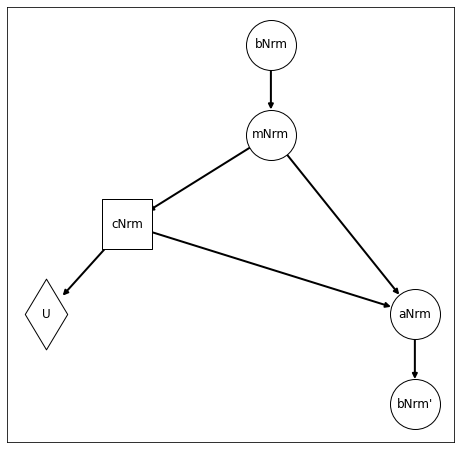

In [4]:
draw_frame_model(frame_model_A)

In [35]:
isinstance(list(frame_model_A.frames.var('bNrm').parents.values())[0], BackwardFrameReference)

True

## Modifying the model

-- To refactor to use standalone models

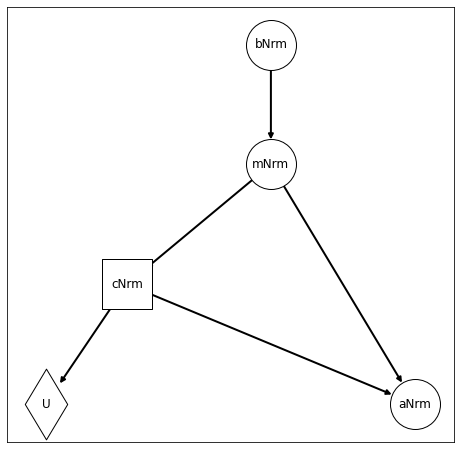

In [6]:
draw_frame_model(frame_model_A.make_terminal())

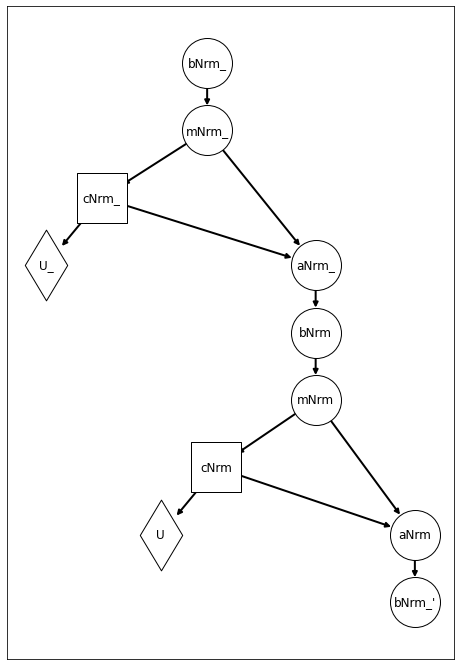

In [7]:
double_model = frame_model_A.prepend(frame_model_A)
draw_frame_model(double_model, figsize = (8,12))

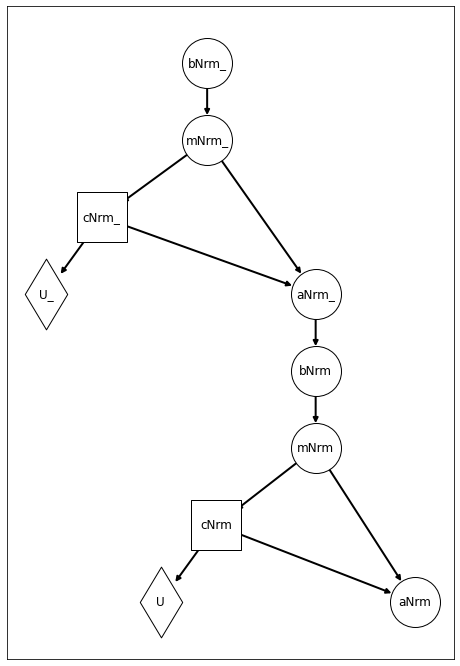

In [8]:
double_model = frame_model_A.make_terminal().prepend(frame_model_A)
draw_frame_model(double_model, figsize = (8,12))

## repeat()

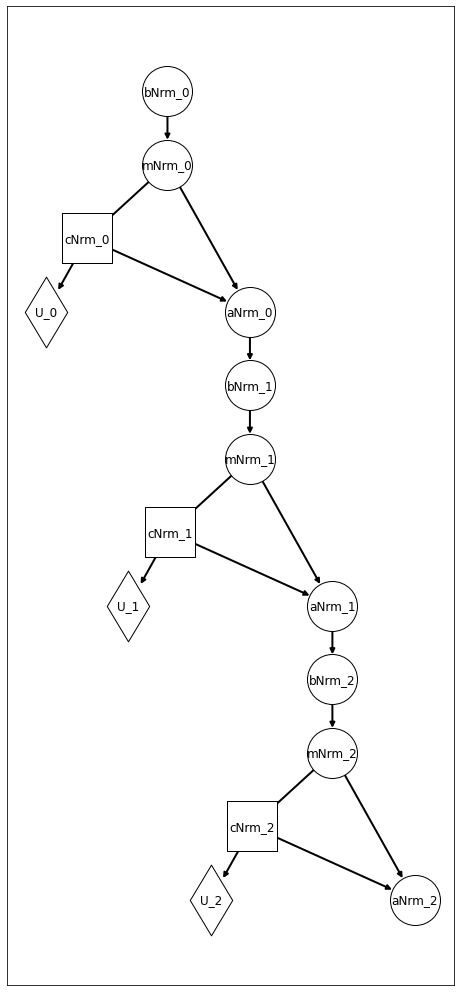

In [9]:
repeat_model = frame_model_A.repeat({'bNrm' : {'Rfree' : [1.01, 1.03, 1.02]}})
draw_frame_model(repeat_model, figsize = (8,18))

In [41]:
repeat_model.frames.var('bNrm_1').context['Rfree']

1.03

## Forward simulating the model

In [11]:
frame_agent_A = FrameAgentType(
    frame_model_A,
    T_sim=5000,
    AgentCount=200,
    read_shocks = True,
    cycles = 0
)

#frame_agent_A.solve()
#frame_agent_A.track_vars += [
#    "mNrm",
#    "cNrm",
#    "aNrm",
#    "bNrm",
#    'U'
#]

# Doesn't work yet.
#frame_agent_A.initialize_sim()
#frame_agent_A.simulate()

In [12]:
## TODO: Forward simulate

## Backwards Induction

In [13]:
model = repeat_model

In [14]:
model.frames

FrameSet([(('bNrm_0',),
           <<class 'HARK.frame.Frame'>, target:('bNrm_0',), scope:('aNrm',)>),
          (('mNrm_0',),
           <<class 'HARK.frame.Frame'>, target:('mNrm_0',), scope:('bNrm_0', 'TranShk_0')>),
          (('cNrm_0',),
           <<class 'HARK.frame.Frame'>, target:('cNrm_0',), scope:('mNrm_0',)>),
          (('U_0',),
           <<class 'HARK.frame.Frame'>, target:('U_0',), scope:('cNrm_0', 'CRRA_0')>),
          (('aNrm_0',),
           <<class 'HARK.frame.Frame'>, target:('aNrm_0',), scope:('mNrm_0', 'cNrm_0')>),
          (('bNrm_1',),
           <<class 'HARK.frame.Frame'>, target:('bNrm_1',), scope:('aNrm_0',)>),
          (('mNrm_1',),
           <<class 'HARK.frame.Frame'>, target:('mNrm_1',), scope:('bNrm_1', 'TranShk_1')>),
          (('cNrm_1',),
           <<class 'HARK.frame.Frame'>, target:('cNrm_1',), scope:('mNrm_1',)>),
          (('U_1',),
           <<class 'HARK.frame.Frame'>, target:('U_1',), scope:('cNrm_1', 'CRRA_1')>),
          (('aNrm_

In [15]:
def create_value_function_from_reward_transition(transition, local_context):
    
    def value_function(**parent_state):
        inputs = parent_state.copy()
        inputs.update(local_context)

        return transition(**inputs)
    
    return value_function

In [16]:
for f in range(len(model.frames)-1,0,-1):
    frame = model.frames.iloc(f)
    
    if frame.reward:
        frame.value = create_value_function_from_reward_transition(
            frame.transition,
            frame.context
        )
    
    elif frame.control:
        pass
    
    elif len(frame.children) == 0:
        # terminal chance node
        
        pass
    
    else:
        # intermediate state node
        pass

In [17]:
model.frames.iloc(3).context

{'CRRA': 2.0}

In [18]:
model.frames.iloc(3).value(**{'cNrm' : 2})

(-0.5,)

## Progressively more complex models

In [19]:
# TODO: streamline this so it can draw the parameters from context
def birth_aNrmNow(self, N):
    """
    Birth value for aNrmNow
    """
    return Lognormal(
        mu=self.aNrmInitMean,
        sigma=self.aNrmInitStd,
        seed=self.RNG.randint(0, 2 ** 31 - 1),
    ).draw(N)

def transition_Rport(self, **context):
    Rport = (
        context["Share"] * context["Risky"]
        + (1.0 - context["Share"]) * self.parameters['Rfree']
    )
    return Rport, 

def transition_bNrm(self, **context):
    aNrmPrev = context['aNrm']
    # This should be computed separately in its own transition
    # Using IndShock get_Rfree instead of generic.
    RfreeNow = context['Rport']

    # "Effective" interest factor on normalized assets
    ReffNow = RfreeNow / context['PermShk']
    bNrmNow = ReffNow * aNrmPrev         # Bank balances before labor income

    return bNrmNow

def transition_mNrm(self, **context):
    mNrm = context['bNrm'] + context['TranShk']  # Market resources after income

    return mNrm


def transition_poststates(self, **context):
    """
    Calculates end-of-period assets for each consumer of this type.

    Parameters
    ----------
    None

    Returns
    -------
    None
    """
    # should this be "Now", or "Prev"?!?
    # todo: don't store on self
    self.state_now['aNrm'] = context['mNrm'] - context['cNrm']
    # Useful in some cases to precalculate asset level

    return (self.state_now['aNrm'])

# maybe replace reference to init_portfolio to self.parameters?
frame_model_B = FrameModel([
    # todo : make an aggegrate value
    Frame(
        ('PermShk'), None,
        default = {'PermShk' : 1.0}, # maybe this is unnecessary because the shock gets sampled at t = 0
        # this is discretized before it's sampled
        transition = IndexDistribution(
                Lognormal.from_mean_std,
                {
                    'mean' : init_parameters['PermGroFac'],
                    'std' : init_parameters['PermShkStd']
                }
            ).approx(
                init_parameters['PermShkCount'], tail_N=0
            ),
    ),
    Frame(
        ('TranShk'), None,
        default = {'TranShk' : 1.0}, # maybe this is unnecessary because the shock gets sampled at t = 0
        transition = IndexDistribution(
                MeanOneLogNormal,
                {
                    'sigma' : init_parameters['TranShkStd']
                }).approx(
                     init_parameters['TranShkCount'], tail_N=0
                ),
    ),
    Frame(
        ('Rport'), ('Share', 'Risky'), 
        transition = transition_Rport
    ),
    Frame(
        ('bNrm',),
        ('aNrm', 'Rport', 'PermShk'),
        transition = transition_bNrm
    ),
    Frame(
        ('mNrm',),
        ('bNrm', 'TranShk'),
        transition = transition_mNrm
    ),
    Frame(
        ('cNrm'), ('Adjust','mNrm','Share'), 
        control = True
    ),
    Frame(
        ('U'), 
        ('cNrm','CRRA'), ## Note CRRA here is a parameter not a state var            transition = lambda self, cNrm, CRRA : (CRRAutility(cNrm, CRRA),),
        reward = True
    ),
    Frame(
        ('aNrm'), ('mNrm', 'cNrm'),
        default = {'aNrm' : birth_aNrmNow},
        transition = lambda self, mNrm, cNrm : (mNrm - cNrm,)
    )],
    init_parameters
)


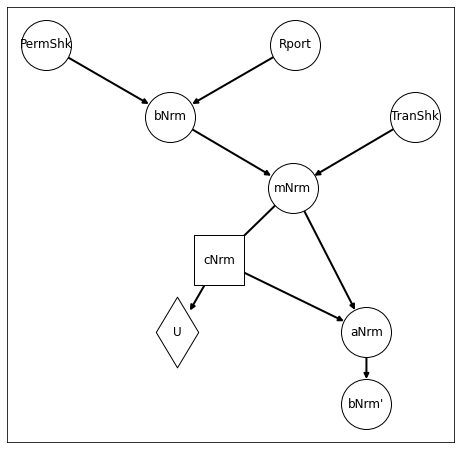

In [20]:
draw_frame_model(frame_model_B)

In [21]:
# TODO: streamline this so it can draw the parameters from context
def birth_aNrmNow(self, N):
    """
    Birth value for aNrmNow
    """
    return Lognormal(
        mu=self.aNrmInitMean,
        sigma=self.aNrmInitStd,
        seed=self.RNG.randint(0, 2 ** 31 - 1),
    ).draw(N)

def transition_Rport(self, **context):
    Rport = (
        context["Share"] * context["Risky"]
        + (1.0 - context["Share"]) * self.parameters['Rfree']
    )
    return Rport, 

def transition_bNrm(self, **context):
    aNrmPrev = context['aNrm']
    # This should be computed separately in its own transition
    # Using IndShock get_Rfree instead of generic.
    RfreeNow = context['Rport']

    # "Effective" interest factor on normalized assets
    ReffNow = RfreeNow / context['PermShk']
    bNrmNow = ReffNow * aNrmPrev         # Bank balances before labor income

    return bNrmNow

def transition_mNrm(self, **context):
    mNrm = context['bNrm'] + context['TranShk']  # Market resources after income

    return mNrm

def transition_poststates(self, **context):
    """
    Calculates end-of-period assets for each consumer of this type.

    Parameters
    ----------
    None

    Returns
    -------
    None
    """
    
    # should this be "Now", or "Prev"?!?
    # todo: don't store on self
    self.state_now['aNrm'] = context['mNrm'] - context['cNrm']
    # Useful in some cases to precalculate asset level

    return (self.state_now['aNrm'])

    # maybe replace reference to init_portfolio to self.parameters?
frame_model_C = FrameModel([
    # todo : make an aggegrate value
    Frame(
        ('PermShk'), None,
        default = {'PermShk' : 1.0}, # maybe this is unnecessary because the shock gets sampled at t = 0
        # this is discretized before it's sampled
        transition = IndexDistribution(
            Lognormal.from_mean_std,
                {
                    'mean' : init_parameters['PermGroFac'],
                    'std' : init_parameters['PermShkStd']
                }
            ).approx(
            init_parameters['PermShkCount'], tail_N=0
            ),
    ),
    Frame(
        ('TranShk'), None,
        default = {'TranShk' : 1.0}, # maybe this is unnecessary because the shock gets sampled at t = 0
        transition = IndexDistribution(
                MeanOneLogNormal,
                {
                    'sigma' : init_parameters['TranShkStd']
                }).approx(
                    init_parameters['TranShkCount'], tail_N=0
                ),
    ),
    Frame( ## TODO: Handle Risky as an Aggregate value
        ('Risky'),None, 
        transition = IndexDistribution(
            Lognormal.from_mean_std,
            {
                'mean' : init_parameters['RiskyAvg'],
                'std' : init_parameters['RiskyStd']
            }
            # seed=self.RNG.randint(0, 2 ** 31 - 1) : TODO: Seed logic
        ).approx(
               init_parameters['RiskyCount']
        ),
        aggregate = True
    ),
    Frame(
        ('Rport'), ('Share', 'Risky'), 
        transition = transition_Rport
    ),
    Frame(
        ('bNrm',),
        ('aNrm', 'Rport', 'PermShk'),
        transition = transition_bNrm
    ),
    Frame(
        ('mNrm',),
        ('bNrm', 'TranShk'),
        transition = transition_mNrm
    ),
    Frame(
        ('Share'), ('Adjust', 'mNrm'),
        default = {'Share' : 0}, 
        control = True
    ),
    Frame(
        ('cNrm'), ('Adjust','mNrm','Share'), 
        control = True
    ),
    Frame(
        ('U'), ('cNrm','CRRA'), ## Note CRRA here is a parameter not a state var
        transition = lambda self, cNrm, CRRA : (CRRAutility(cNrm, CRRA),),
        reward = True
    ),
    Frame(
        ('aNrm'), ('mNrm', 'cNrm'),
        default = {'aNrm' : birth_aNrmNow},
        transition = lambda self, mNrm, cNrm : (mNrm - cNrm,)
    ),
], init_parameters)


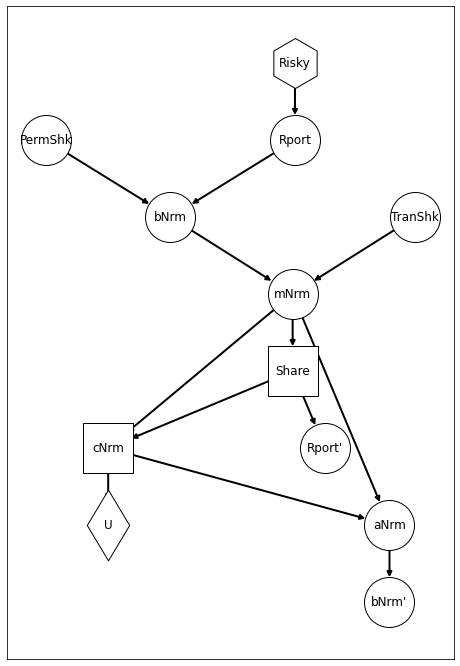

In [22]:
draw_frame_model(frame_model_C, figsize=(8,12))